# AquaYOLO model for Underwater Object Detection

This is a replication of the model/architecture purposed in **AquaYOLO: Enhancing YOLOv8 for Accurate Underwater Object Detection for Sonar Images**. The paper can be found at [this link](https://www.mdpi.com/2077-1312/13/1/73). 

## Dataset Setup

Using the UATD dataset:

- Download the dataset from [here](hhttps://figshare.com/articles/dataset/UATD_Dataset/21331143/3). Download all 4 zips.
- Create ./data folder within the model. (Like this: ./aqua_yolo/data)
- Place the downloaded .zip files inside the data-folder
- Then unzip them manually or running code below:

In [2]:
import zipfile
import os

zip_paths = [ "data/UATD_Test_1.zip", "data/UATD_Test_2.zip", "data/UATD_Training.zip",]
extract_dir = "data/UATD/"

# Make sure the target directory exists
os.makedirs(extract_dir, exist_ok=True)

for zip_path in zip_paths:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(zip_path, " extracted to:", os.path.abspath(extract_dir))

data/UATD_Test_1.zip  extracted to: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD
data/UATD_Test_2.zip  extracted to: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD
data/UATD_Training.zip  extracted to: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD


### What data?

In [2]:
import zipfile
import os

zip_paths = [ "data/UATD_Test_1.zip", "data/UATD_Test_2.zip", "data/UATD_Training.zip",]
extract_dir = "data/UATD/"

# Make sure the target directory exists
os.makedirs(extract_dir, exist_ok=True)

for zip_path in zip_paths:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(zip_path, " extracted to:", os.path.abspath(extract_dir))

KeyboardInterrupt: 

### Setup on YOLO format

In [4]:
# Set up the paths

from pathlib import Path

ROOT = Path.cwd()
DATA = ROOT / "data" / "UATD"

UATD_TRAIN = DATA / "UATD_Training"
UATD_VAL   = DATA / "UATD_Test_1"
UATD_TEST  = DATA / "UATD_Test_2"

# YOLO folders directly inside UATD/
YOLO_IMG = DATA / "images"
YOLO_LBL = DATA / "labels"

# Create standard YOLO directory tree
for split in ["train", "val", "test"]:
    (YOLO_IMG / split).mkdir(parents=True, exist_ok=True)
    (YOLO_LBL / split).mkdir(parents=True, exist_ok=True)

print("✅ YOLO structure ready at:", DATA)


✅ YOLO structure ready at: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD


In [5]:
# Convert XMLs → YOLO labels

import glob, shutil
from xml.etree import ElementTree as ET

SPLIT_MAP = {
    "train": UATD_TRAIN,
    "val":   UATD_VAL,
    "test":  UATD_TEST,
}

def parse_box(obj):
    bb = obj.find("bndbox")
    return (
        float(bb.findtext("xmin")),
        float(bb.findtext("ymin")),
        float(bb.findtext("xmax")),
        float(bb.findtext("ymax")),
    )

def voc_to_yolo(xmin, ymin, xmax, ymax, w, h):
    cx = ((xmin + xmax) / 2) / w
    cy = ((ymin + ymax) / 2) / h
    bw = (xmax - xmin) / w
    bh = (ymax - ymin) / h
    return cx, cy, bw, bh

def sanitize(name: str):
    return name.strip().replace(" ", "-").lower()

def convert_to_yolo():
    class_to_id, classes = {}, []

    for split, src_dir in SPLIT_MAP.items():
        ann_dir = src_dir / "annotations"
        img_dir = src_dir / "images"
        xmls = sorted(glob.glob(str(ann_dir / "*.xml")))
        print(f"[{split}] Found {len(xmls)} XMLs")

        for xml in xmls:
            root = ET.parse(xml).getroot()
            w = int(root.find("size").findtext("width"))
            h = int(root.find("size").findtext("height"))
            fname = root.find("file").findtext("filename") or Path(xml).stem
            stem = Path(fname).stem
            img_src = img_dir / f"{stem}.bmp"

            if not img_src.exists():
                print(f"⚠️ Missing image for {stem}.bmp")
                continue

            # Write YOLO label
            lbl_path = YOLO_LBL / split / f"{stem}.txt"
            with open(lbl_path, "w") as y:
                for obj in root.findall("object"):
                    cname = sanitize(obj.findtext("name"))
                    if cname not in class_to_id:
                        class_to_id[cname] = len(classes)
                        classes.append(cname)
                    cls_id = class_to_id[cname]
                    xmin, ymin, xmax, ymax = parse_box(obj)
                    cx, cy, bw, bh = voc_to_yolo(xmin, ymin, xmax, ymax, w, h)
                    y.write(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

            # Copy image to YOLO folder
            dst_img = YOLO_IMG / split / img_src.name
            if not dst_img.exists():
                shutil.copy2(img_src, dst_img)

    print("✅ Conversion complete.")
    print("Classes:", classes)
    return classes

CLASSES = convert_to_yolo()


[train] Found 7600 XMLs
[val] Found 800 XMLs
[test] Found 800 XMLs
✅ Conversion complete.
Classes: ['human-body', 'ball', 'circle-cage', 'square-cage', 'tyre', 'metal-bucket', 'cube', 'cylinder', 'plane', 'rov']


In [7]:
# --- Class summary per split + recover class->id mapping from .txt labels ---
from pathlib import Path
from collections import Counter, defaultdict
import glob
from xml.etree import ElementTree as ET

# Where your label .txt files were written:
LABELS_ROOT = Path("data/UATD/labels")  # adjust if different

def summarize_split_classes_with_ids():
    def sanitize(name: str):
        return name.strip().replace(" ", "-").lower()

    # These come from your earlier code
    split_to_xml_root = SPLIT_MAP  # { 'train': Path(...), 'val': Path(...), 'test': Path(...) }

    # Global mapping we’ll infer: name -> id(s) and id -> name(s)
    name_to_ids = defaultdict(set)
    id_to_names = defaultdict(set)

    all_union = set()
    per_split = {}

    for split, src_dir in split_to_xml_root.items():
        ann_dir = src_dir / "annotations"
        lbl_dir = LABELS_ROOT / split

        xmls = sorted(glob.glob(str(ann_dir / "*.xml")))
        uniq = set()
        counts = Counter()

        for xml in xmls:
            root = ET.parse(xml).getroot()
            # collect object names in the order they appear
            obj_names = [sanitize(o.findtext("name")) for o in root.findall("object")]
            if not obj_names:
                continue

            # find corresponding .txt label file (same stem)
            fname = root.find("file").findtext("filename") if root.find("file") is not None else None
            stem = Path(fname).stem if fname else Path(xml).stem
            lbl_path = lbl_dir / f"{stem}.txt"

            # update pure class counts (from XML)
            for cname in obj_names:
                uniq.add(cname)
                counts[cname] += 1

            # if we have a label file, align each object with its class id
            if lbl_path.exists():
                with open(lbl_path) as f:
                    ids_seq = [int(line.split()[0]) for line in f if line.strip()]
                # zip up to the shortest to be safe
                for cname, cid in zip(obj_names, ids_seq):
                    name_to_ids[cname].add(cid)
                    id_to_names[cid].add(cname)

        per_split[split] = {"unique": uniq, "counts": counts}
        all_union |= uniq

    # ---- Pretty print per-split summary (with indices if known) ----
    print("\n==== CLASS SUMMARY PER SPLIT (with label IDs when resolvable) ====")
    for split in ("train", "val", "test"):
        if split not in per_split:
            continue
        uniq = sorted(per_split[split]["unique"])
        counts = per_split[split]["counts"]

        # attach inferred id(s) if we have them
        annotated = []
        for cname in uniq:
            ids = sorted(name_to_ids[cname]) if cname in name_to_ids else []
            tag = f"{cname} (id={ids[0]})" if len(ids) == 1 else (f"{cname} (ids={ids})" if ids else f"{cname}")
            annotated.append(tag)

        print(f"\n[{split.upper()}] classes ({len(uniq)}): {annotated}")
        if counts:
            print("counts:", {k: counts[k] for k in uniq})

    # ---- Missing classes by split (from XML view) ----
    print("\n==== MISSING CLASSES CHECK (by XML) ====")
    for split in ("train", "val", "test"):
        if split not in per_split:
            continue
        missing = sorted(all_union - per_split[split]["unique"])
        if missing:
            print(f"{split}: missing {len(missing)} -> {missing}")
        else:
            print(f"{split}: no missing classes")

    # ---- Final recovered mapping summary ----
    print("\n==== RECOVERED MAPPING FROM LABEL FILES ====")
    # name -> id
    for cname in sorted(name_to_ids):
        ids = sorted(name_to_ids[cname])
        if len(ids) == 1:
            print(f"name → id: {cname:>14}  -> {ids[0]}")
        else:
            print(f"name → id: {cname:>14}  -> {ids}  (⚠ multiple IDs seen)")

    # id -> name
    for cid in sorted(id_to_names):
        names = sorted(id_to_names[cid])
        if len(names) == 1:
            print(f"id   → name: {cid:>3}             -> {names[0]}")
        else:
            print(f"id   → name: {cid:>3}             -> {names}  (⚠ multiple names seen)")

    # Quick consistency warning
    bad = [c for c, s in name_to_ids.items() if len(s) != 1] + [n for n, s in id_to_names.items() if len(s) != 1]
    if bad:
        print("\n⚠ Inconsistency detected (a class mapped to multiple IDs or vice-versa).")
        print("  This usually means the YAML names order doesn’t match label IDs, or labels were mixed.")
    else:
        print("\n✅ Mapping appears consistent (1:1).")

# run it
summarize_split_classes_with_ids()



==== CLASS SUMMARY PER SPLIT (with label IDs when resolvable) ====

[TRAIN] classes (10): ['ball (id=1)', 'circle-cage (id=2)', 'cube (id=6)', 'cylinder (id=7)', 'human-body (id=0)', 'metal-bucket (id=5)', 'plane (id=8)', 'rov (id=9)', 'square-cage (id=3)', 'tyre (id=4)']
counts: {'ball': 3072, 'circle-cage': 661, 'cube': 2647, 'cylinder': 564, 'human-body': 1285, 'metal-bucket': 476, 'plane': 795, 'rov': 700, 'square-cage': 982, 'tyre': 1125}

[VAL] classes (10): ['ball (id=1)', 'circle-cage (id=2)', 'cube (id=6)', 'cylinder (id=7)', 'human-body (id=0)', 'metal-bucket (id=5)', 'plane (id=8)', 'rov (id=9)', 'square-cage (id=3)', 'tyre (id=4)']
counts: {'ball': 197, 'circle-cage': 99, 'cube': 172, 'cylinder': 48, 'human-body': 76, 'metal-bucket': 6, 'plane': 135, 'rov': 150, 'square-cage': 167, 'tyre': 122}

[TEST] classes (10): ['ball (id=1)', 'circle-cage (id=2)', 'cube (id=6)', 'cylinder (id=7)', 'human-body (id=0)', 'metal-bucket (id=5)', 'plane (id=8)', 'rov (id=9)', 'square-cage 

In [8]:
from pathlib import Path

ROOT = Path.cwd()
DATA = ROOT / "data" / "UATD"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA / "images" / "val"
IMAGES_TEST  = DATA / "images" / "test"

dataset_yaml = f"""
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_TEST.as_posix()}

# UATD has 10 classes
names:
  - human-body
  - ball
  - circle-cage
  - square-cage
  - tyre
  - metal-bucket
  - cube
  - cylinder
  - plane
  - rov
"""

yaml_path = DATA / "uatd.yaml"
yaml_path.write_text(dataset_yaml)
print("✅ Wrote:", yaml_path)



✅ Wrote: /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD/uatd.yaml


Look into this, but I think it is ok: the image-names in train/test/val are duplicated. we have 00001.bmp in all three folders. Chat says it is ok because they have different roots. 

### Now lets vizualise some data:


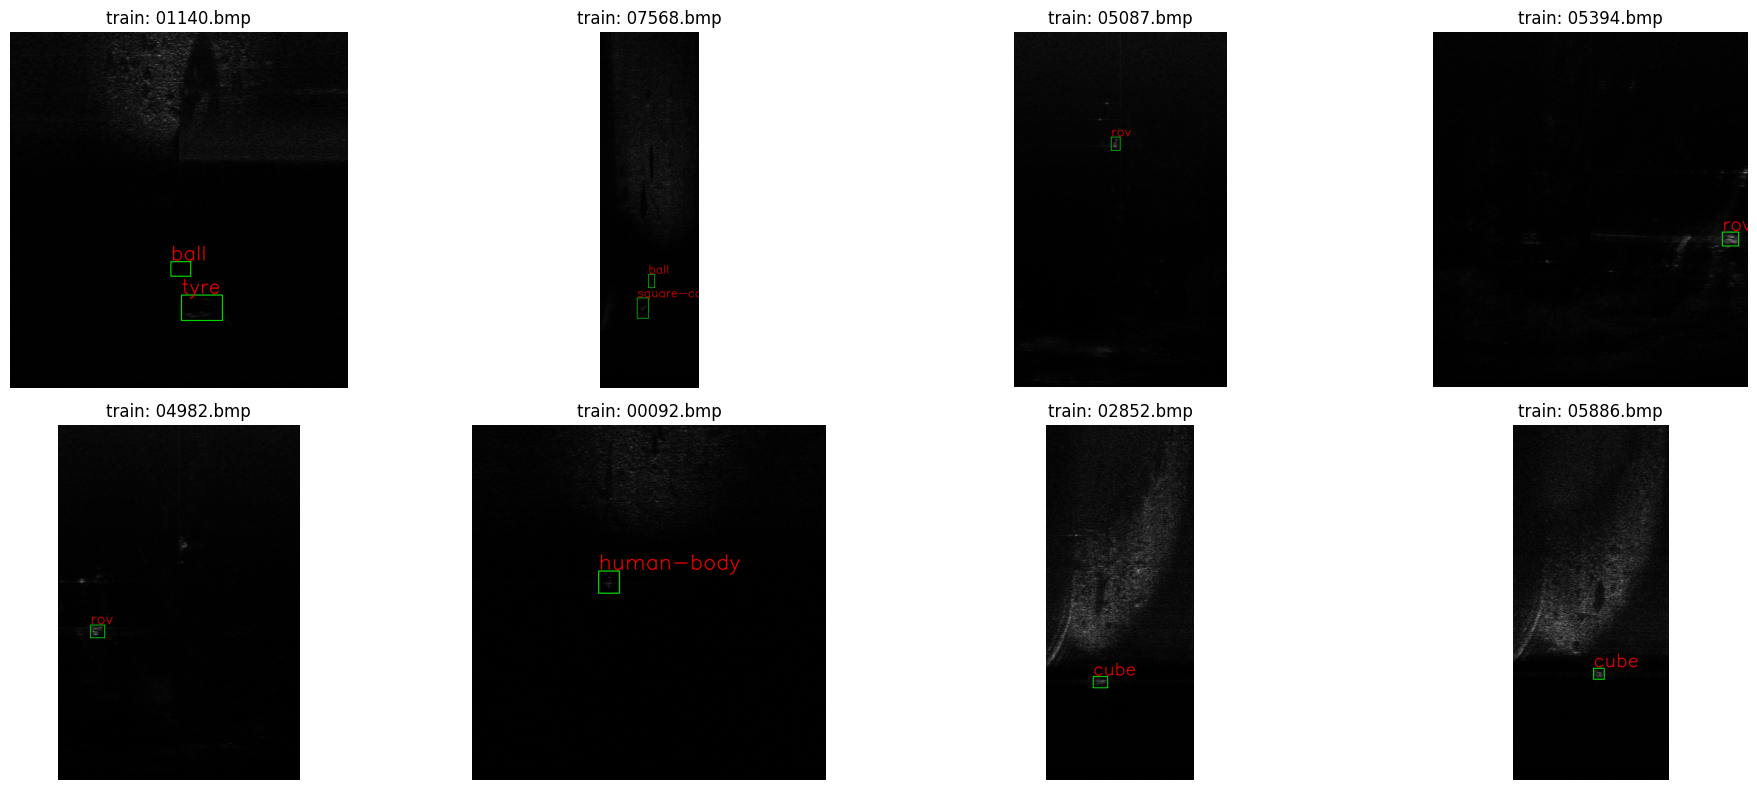

In [9]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import yaml

# ---------------- config ----------------
DATA_ROOT = Path("data/UATD")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "train"   # "train", "val", or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4

# Try to read class names from data/UATD/uatd.yaml; fall back to a default list
NAMES = None
yaml_path = DATA_ROOT / "uatd.yaml"
if yaml_path.exists():
    try:
        y = yaml.safe_load(yaml_path.read_text())
        if isinstance(y.get("names"), list):
            NAMES = y["names"]
        elif isinstance(y.get("names"), dict):
            # sort by numeric key (0..n-1)
            NAMES = [name for _, name in sorted(y["names"].items(), key=lambda kv: int(kv[0]))]
    except Exception as e:
        print("Warning: could not parse names from uatd.yaml:", e)

if not NAMES:
    # Fallback UATD names (lowercase, hyphenated to match our earlier converters)
    NAMES = [
        "cube","ball","cylinder","human-body","plane",
        "circle-cage","square-cage","metal-bucket","tyre","rov"
    ]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)  # green box
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_AA)  # red text
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (prefer ones with labels)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout()
plt.show()


# Building

Building (and training) of the model happens in [train.py](./train.py). The model is constructed by the [aquayolo.yaml](./models/aquayolo.yaml), that imports modules from custom blocks (see paragraph below).


### Adding custom blocks

I have added custom blocks to match the architecture as pruposed in the paper. For this to work I have first cloned the ultralytics repo.
- Head to [ultralytics](https://docs.ultralytics.com/guides/model-yaml-config/#source-code-modification) to see how to add custom blocks.
- Files that is modified: [block.py](../ultralytics/ultralytics/nn/modules/block.py) (classes: AquaResidualBlock, DSAM), [tasks.py](../ultralytics/ultralytics/nn/tasks.py) (added imports and updated parse_model() for special arguments), [__init__.py](../ultralytics/ultralytics/nn/modules/__init__.py) (exposing the modules).



### Is it an accurate replication??

Yes should be pretty good now. Make a detailed description of why **TODO**

# Training

- To train the model run the train.py script by doing: `python3 train.py`

### How I did training

- Using the IDUN computer at NTNU. 
    - Idun settings: 4 GPUS, any. 32 CPU cores, 64 GB RAM, 

- Loaded the pretrained yolov8s to make training faster. 

# Evaluation

### Get results
Here we get the actual results. Files are saved in runs_uwyolo folder.

In [2]:
from ultralytics import YOLO
model = YOLO("runs_aquayolo/aquayolo_m_SGD_640_4gpu_stable2/weights/best.pt")
results = model.val(
    data="data/UATD/uatd.yaml",
    imgsz=640,
    batch=1,
    iou=0.7,
    plots=True,
    project="runs_aquayolo",
    name="aquayolo_eval",
    exist_ok=True
)
print(results)


Ultralytics 8.3.213 🚀 Python-3.9.21 torch-2.8.0+cu128 CUDA:0 (NVIDIA A100-PCIE-40GB, 40441MiB)
aquaYOLO summary: 331 layers, 119,756,606 parameters, 0 gradients, 340.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3684.1±499.8 MB/s, size: 4205.5 KB)
val: Scanning /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/UATD/labels/val.cache... 800 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 800/800 925.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 800/800 45.7it/s 17.5s<0.1s
                   all        800       1172      0.879       0.84      0.829      0.392
            human-body         76         76      0.853      0.868      0.838       0.39
                  ball        197        197      0.834      0.878      0.839      0.447
           circle-cage         99         99       0.72      0.424      0.471      0.228
           square-cage        167        167       0.86      0.625      0.681  

### Show images in Notebook
This is for showing stuff in the notebook. The images are saved in the eval folder (these are not on git)

📈 BoxPR_curve.png


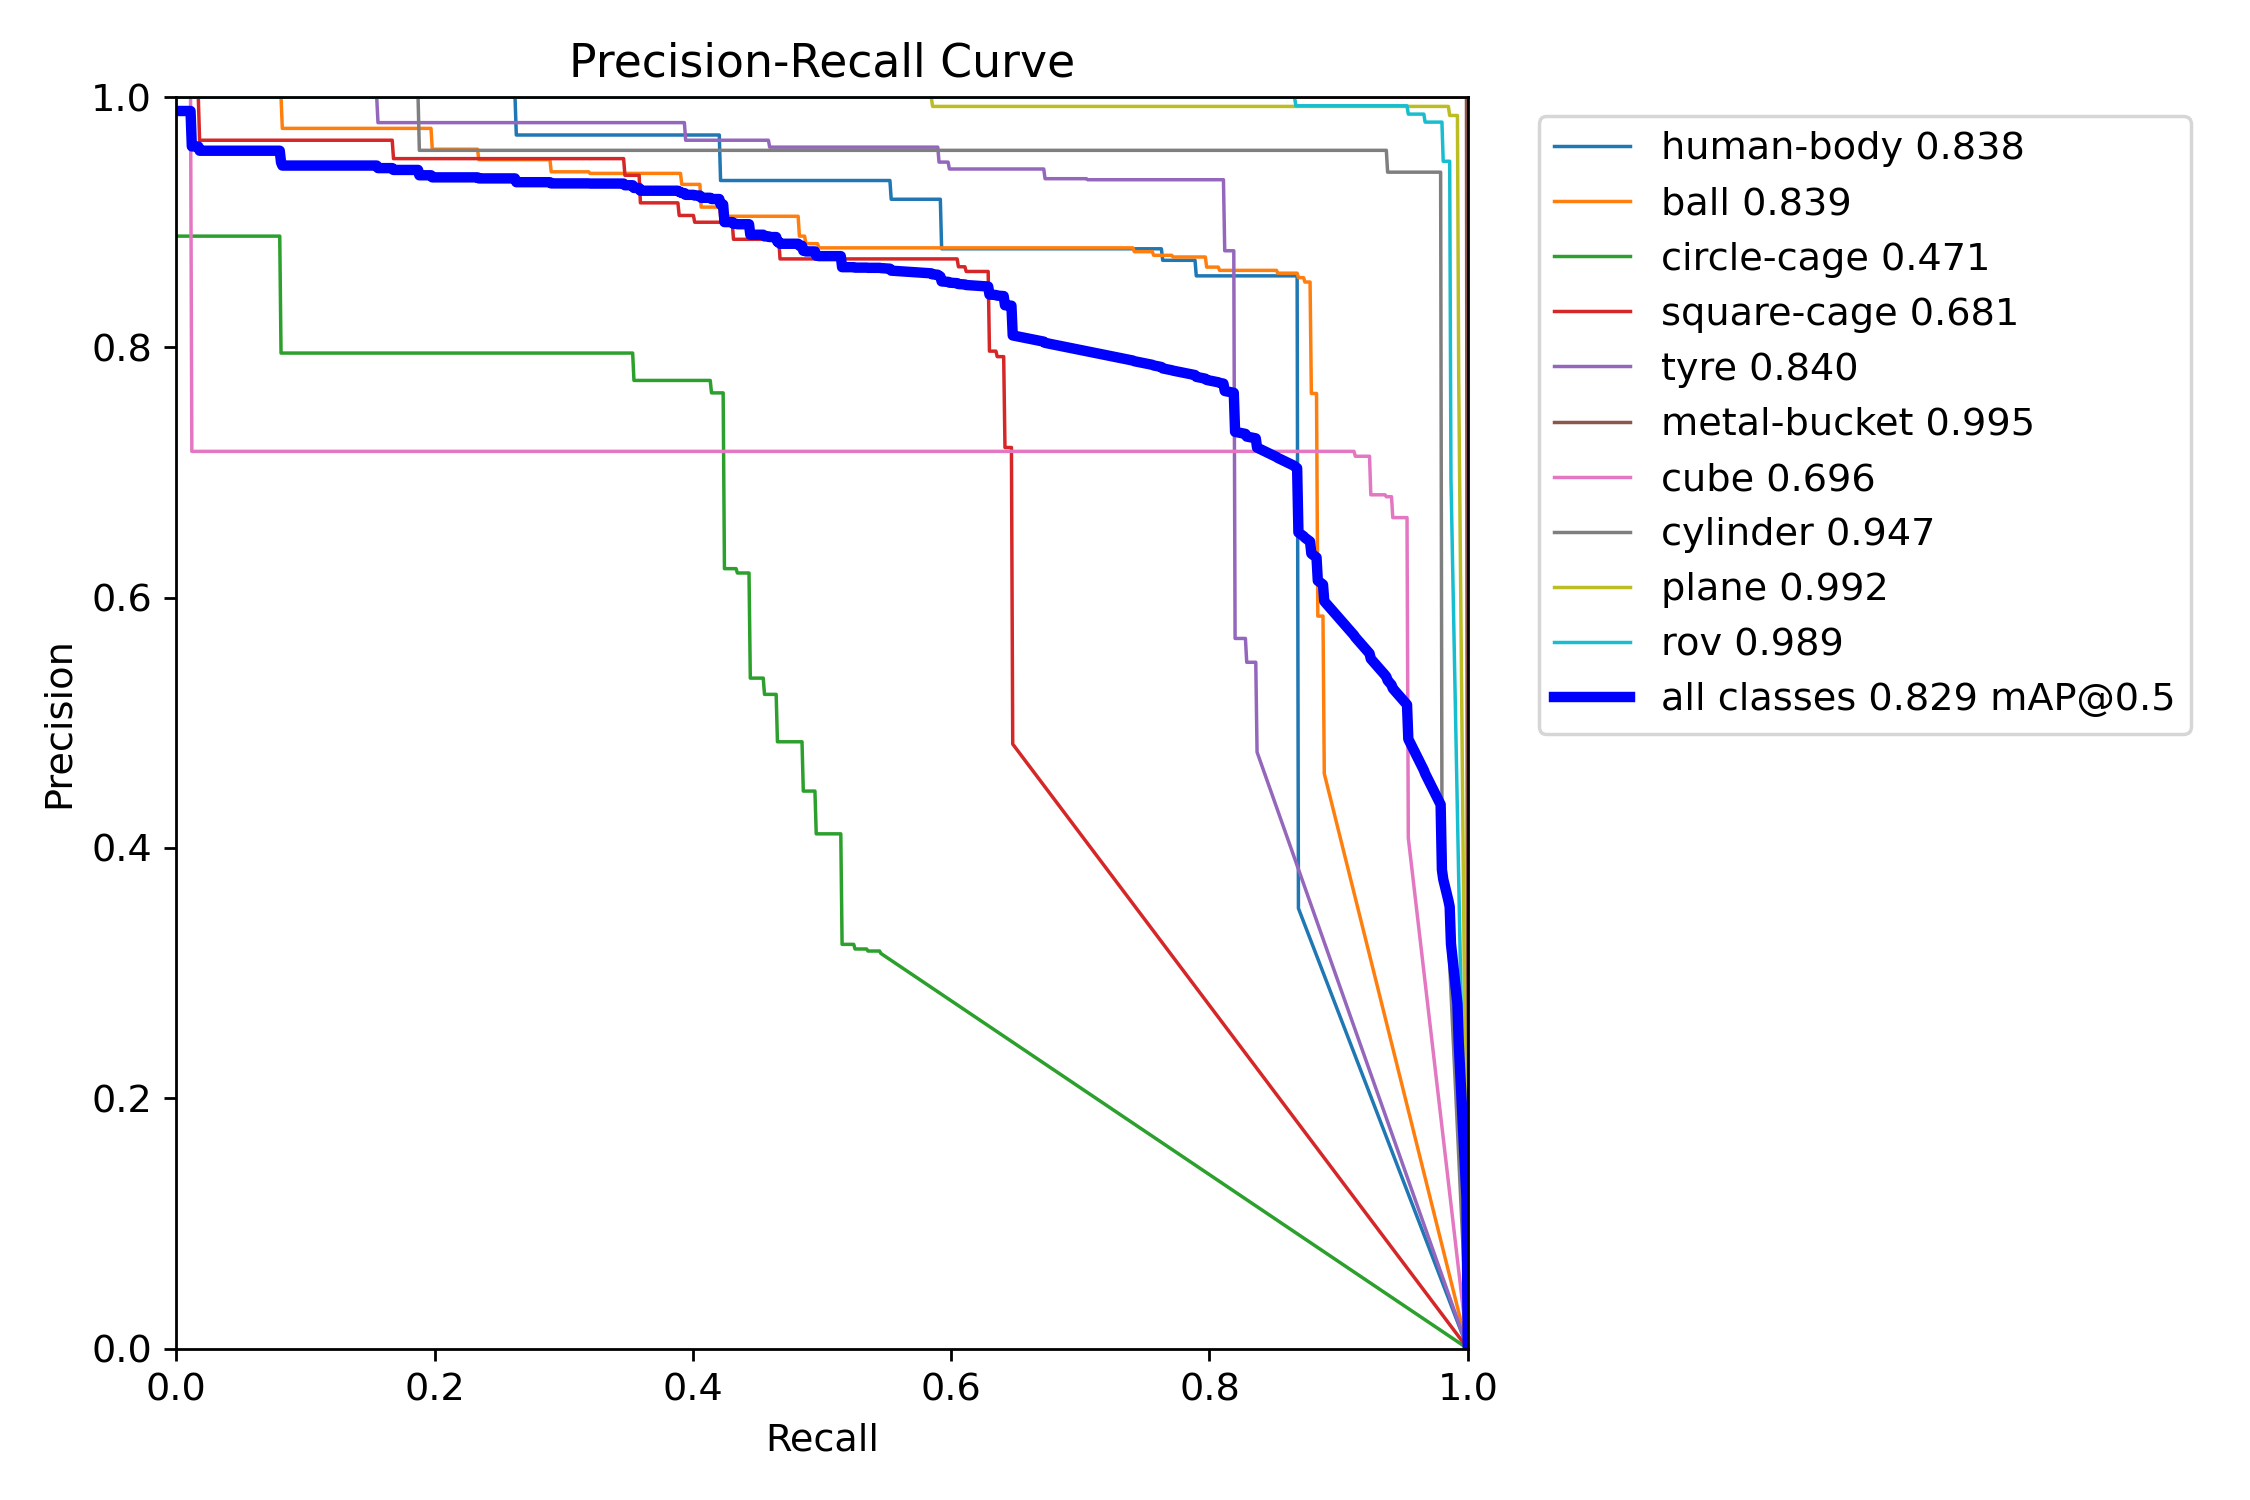

📈 BoxP_curve.png


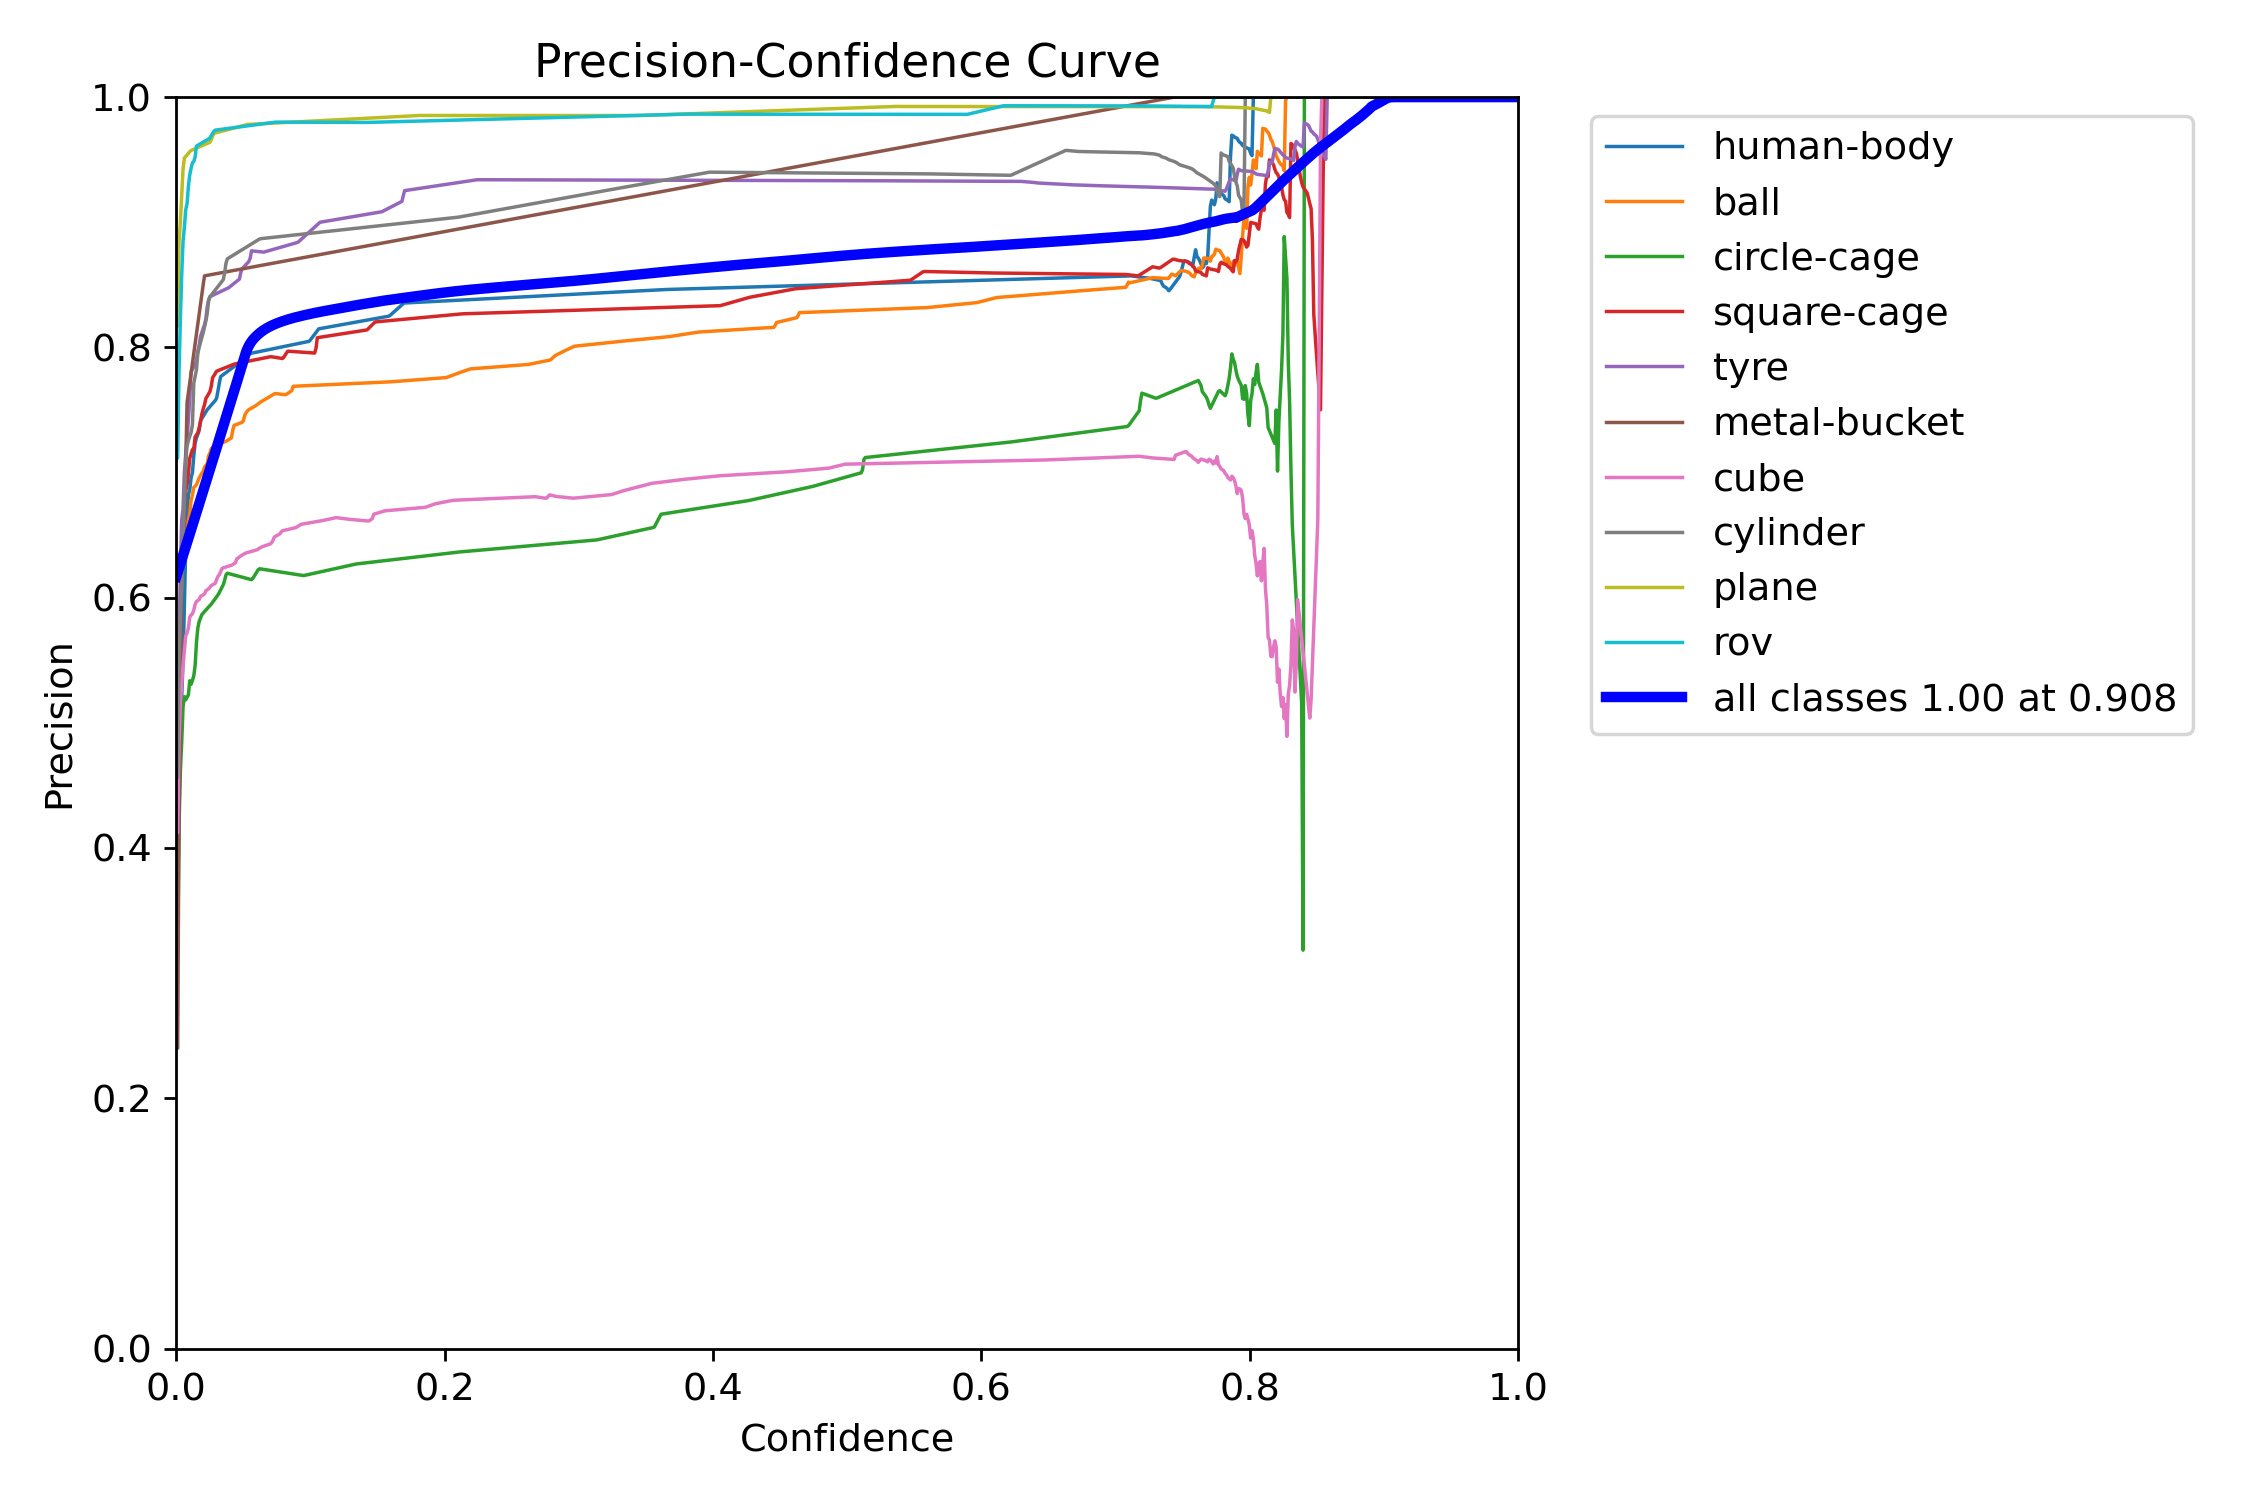

📈 BoxR_curve.png


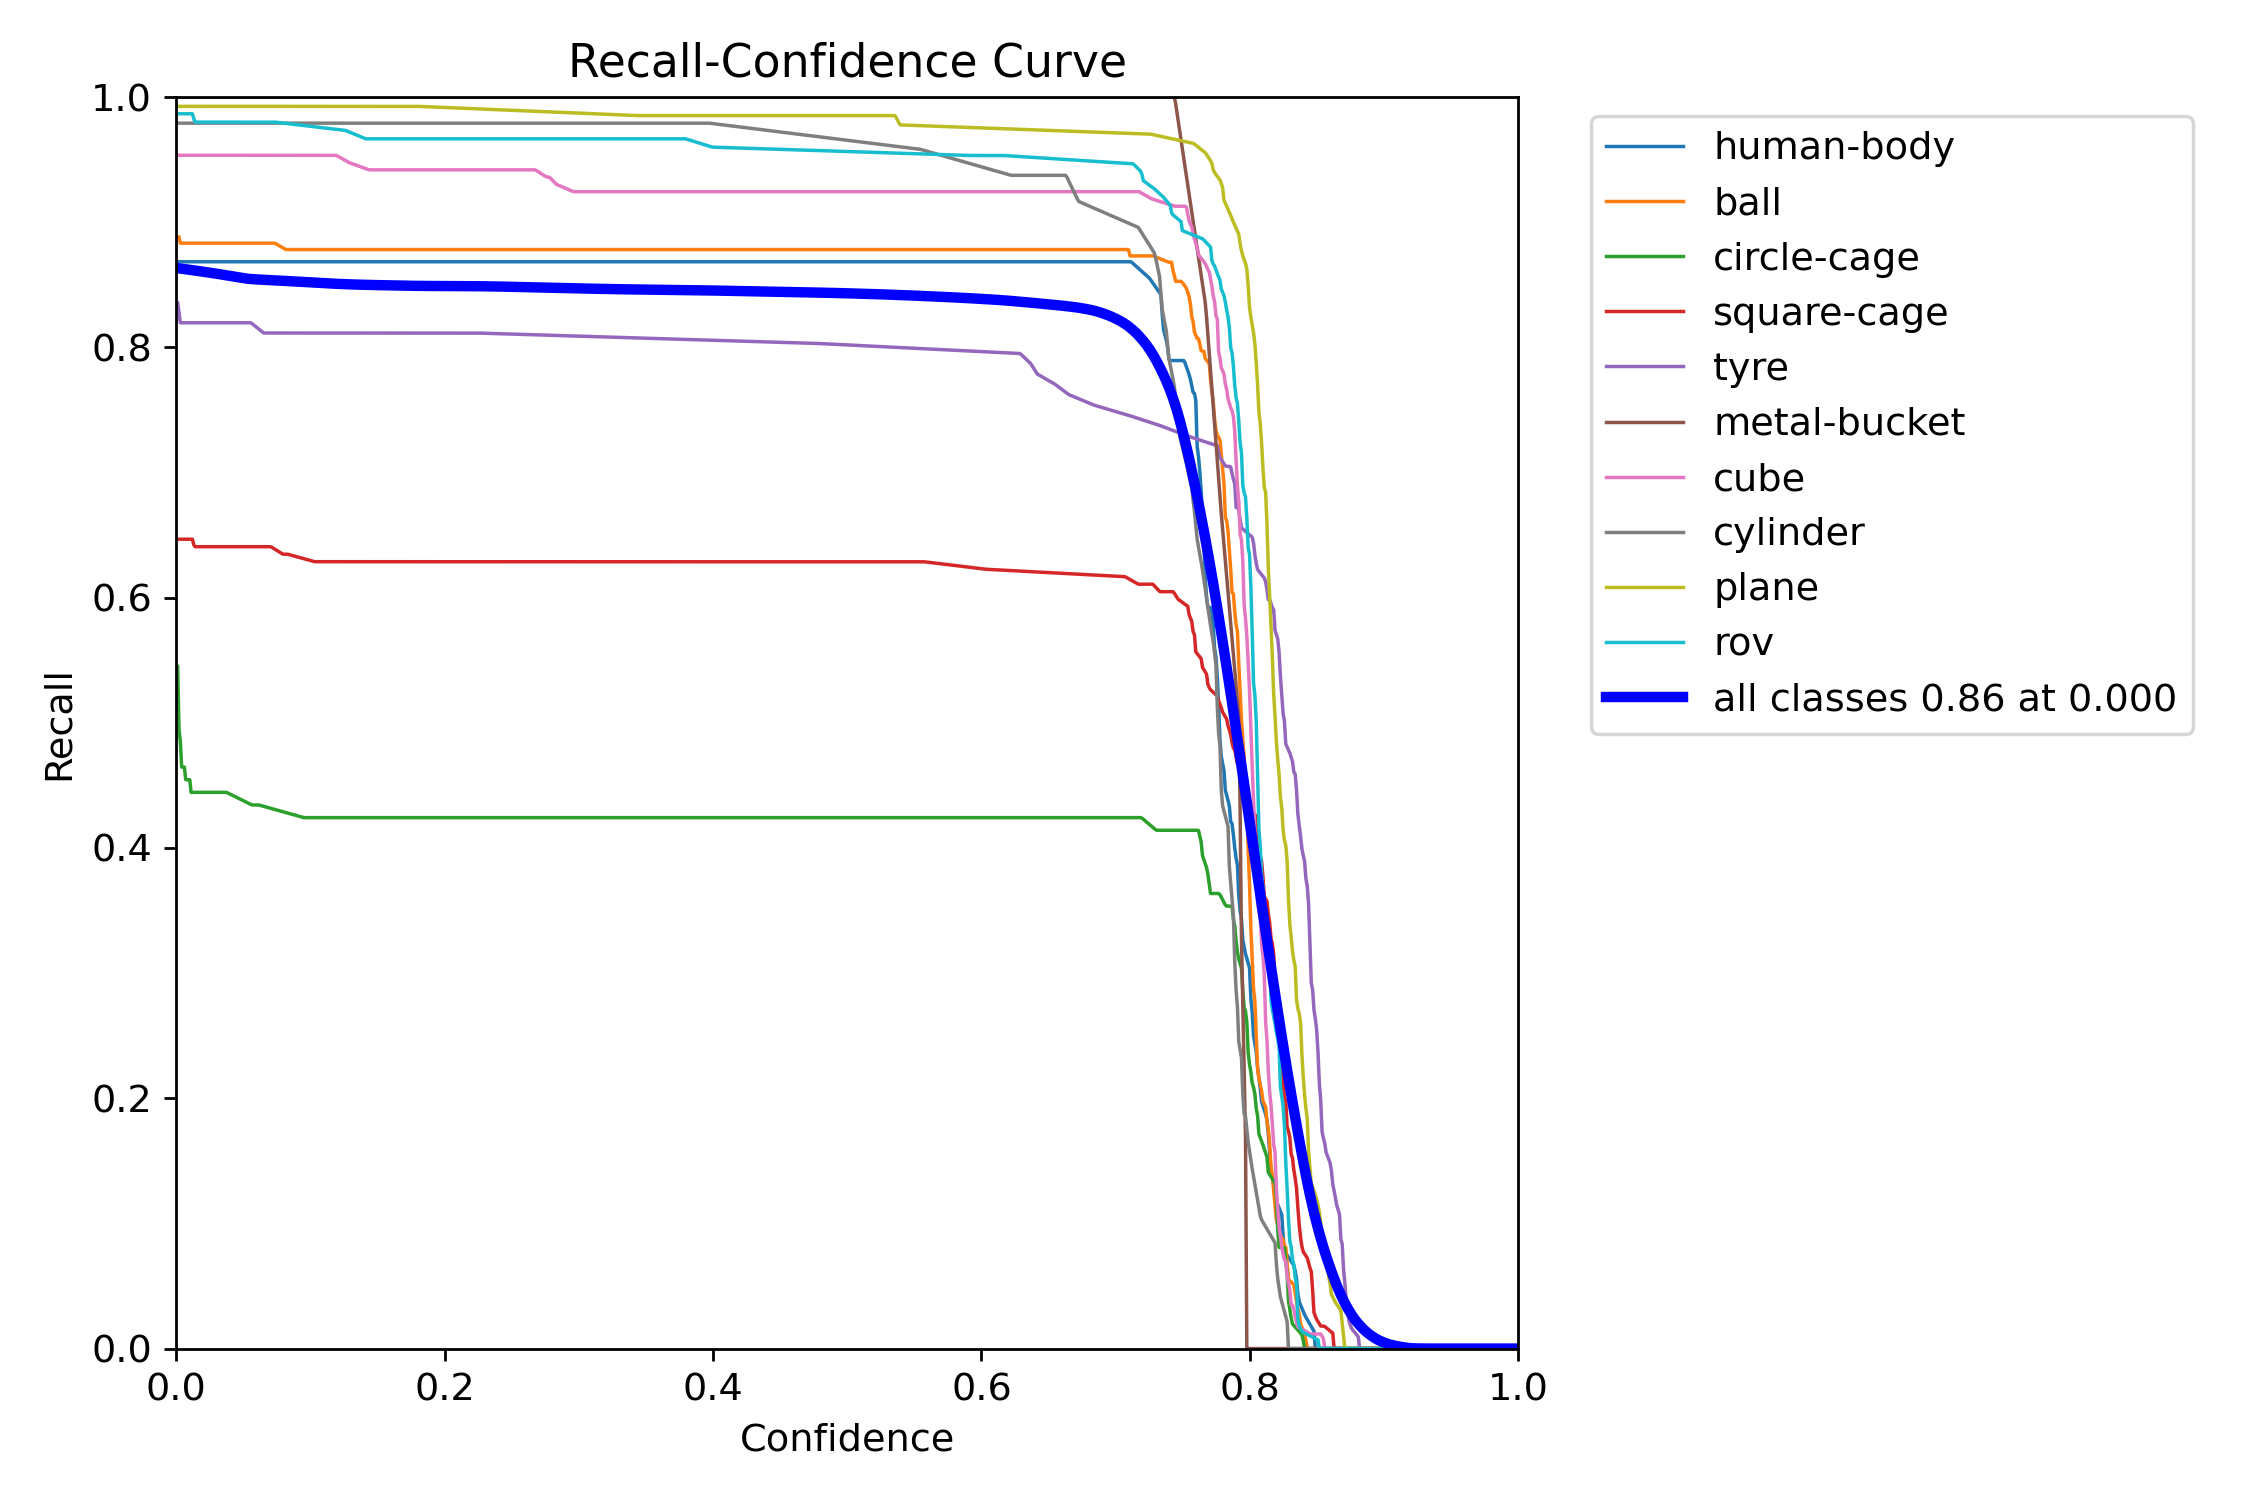

📈 BoxF1_curve.png


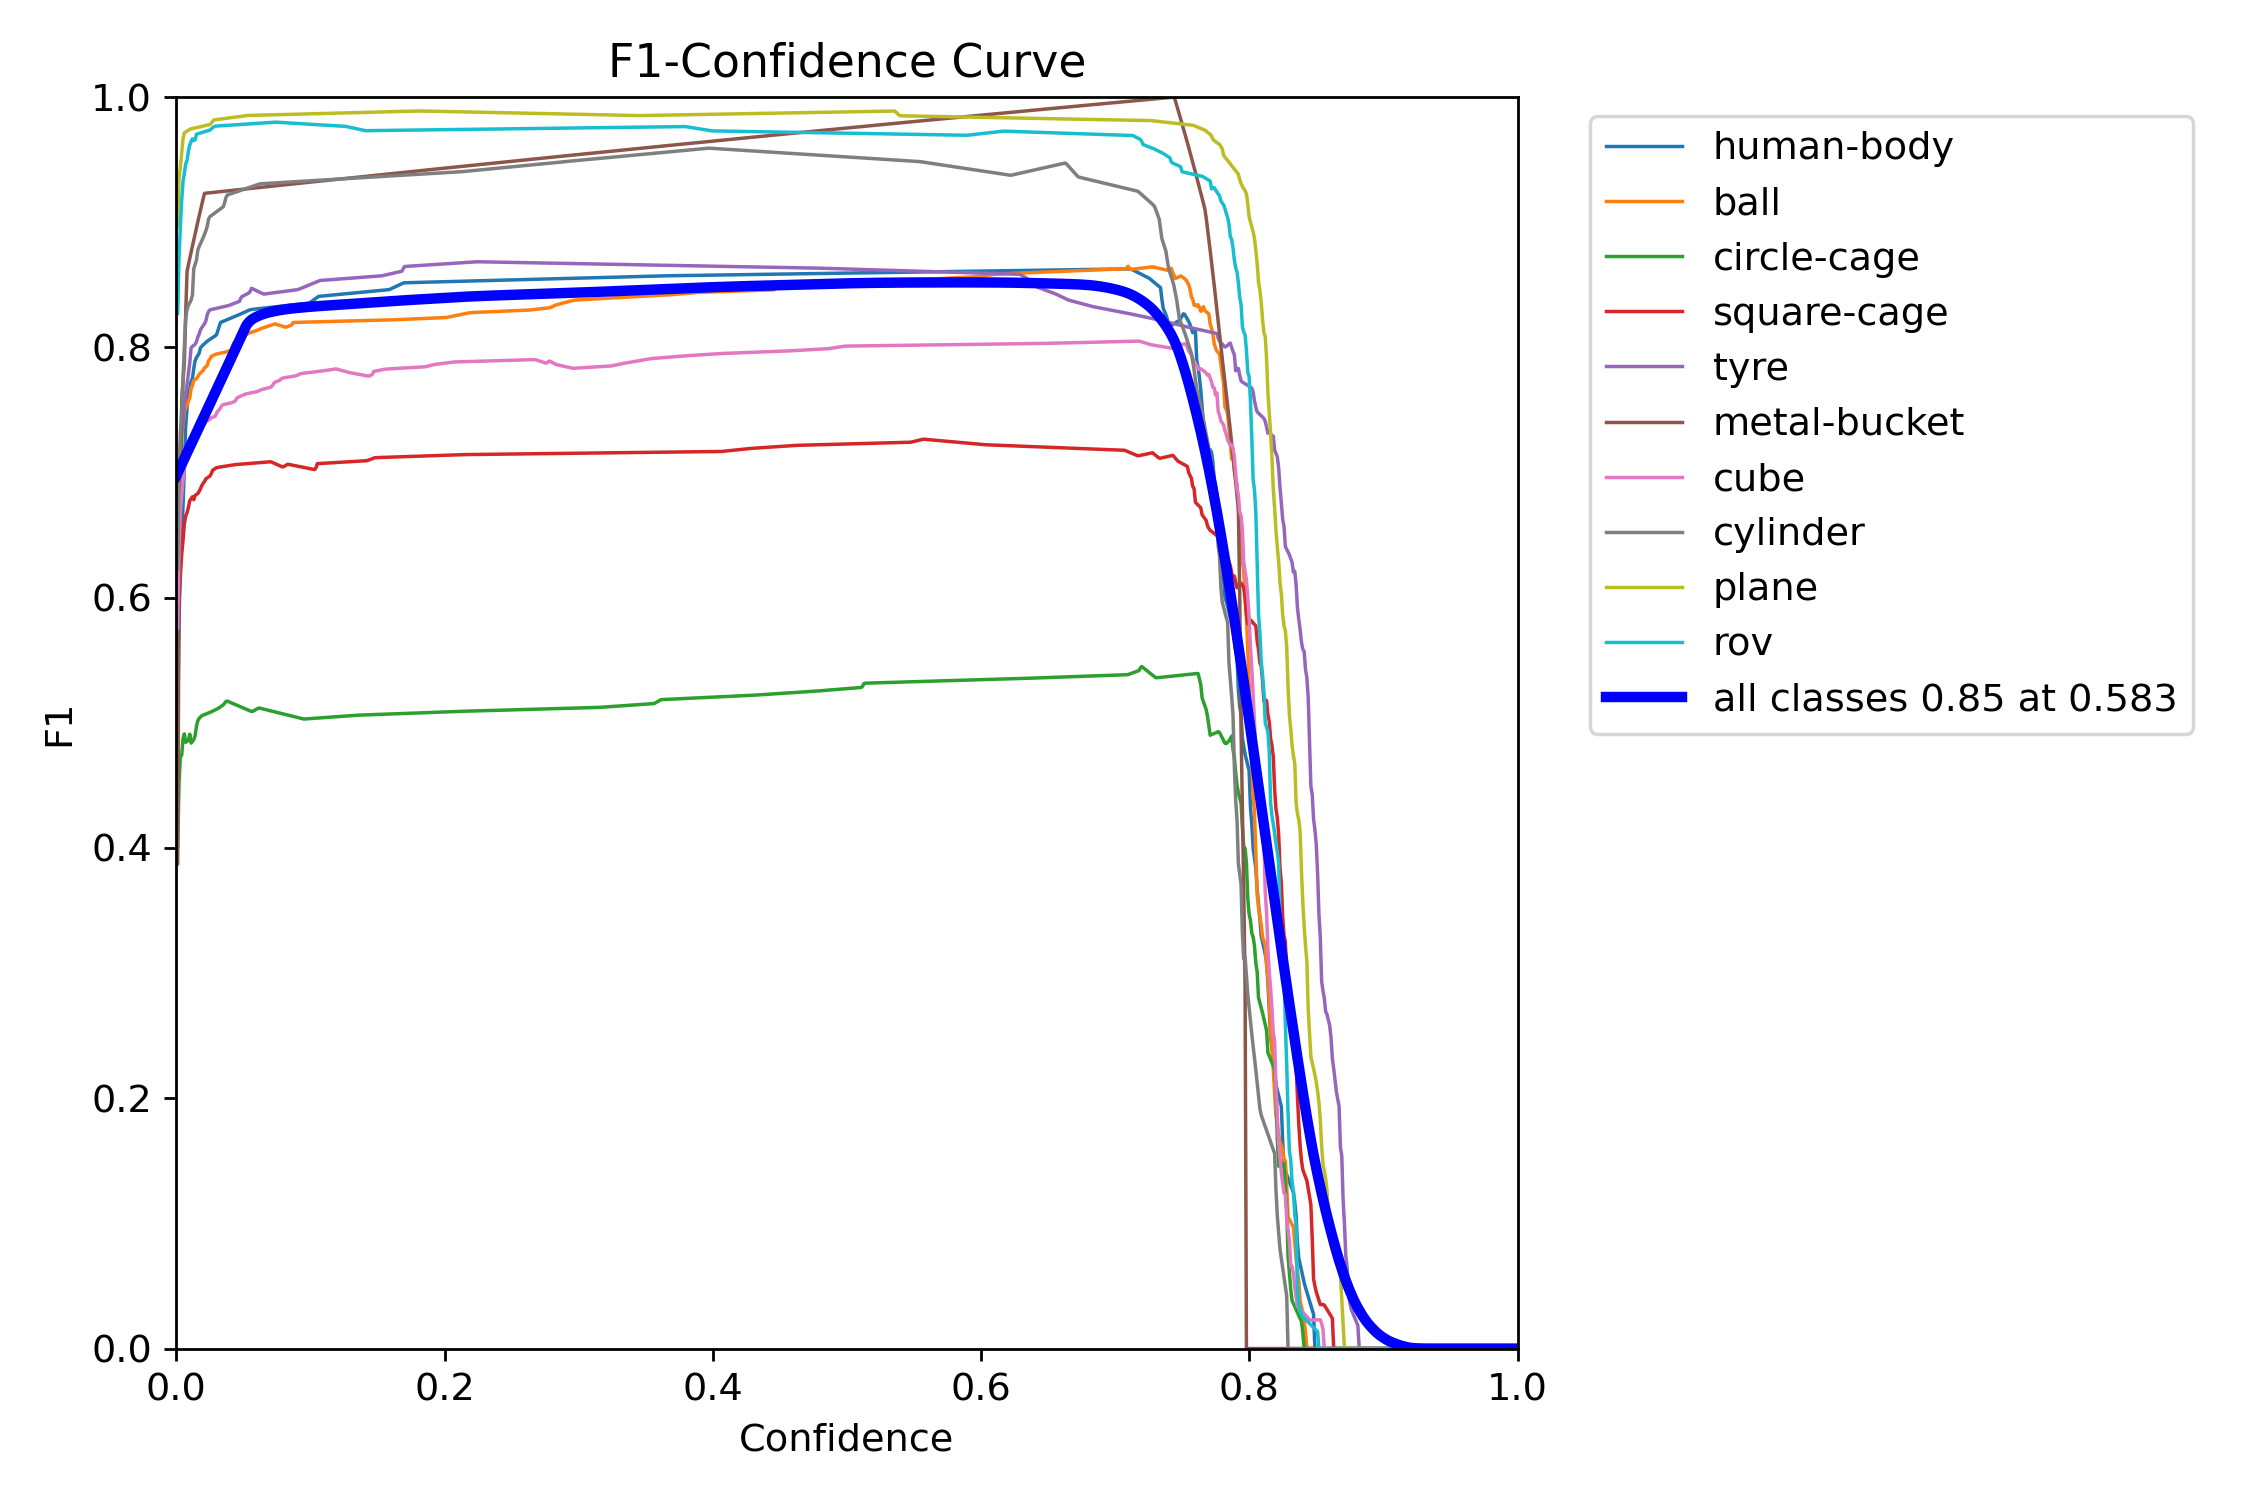

📈 confusion_matrix.png


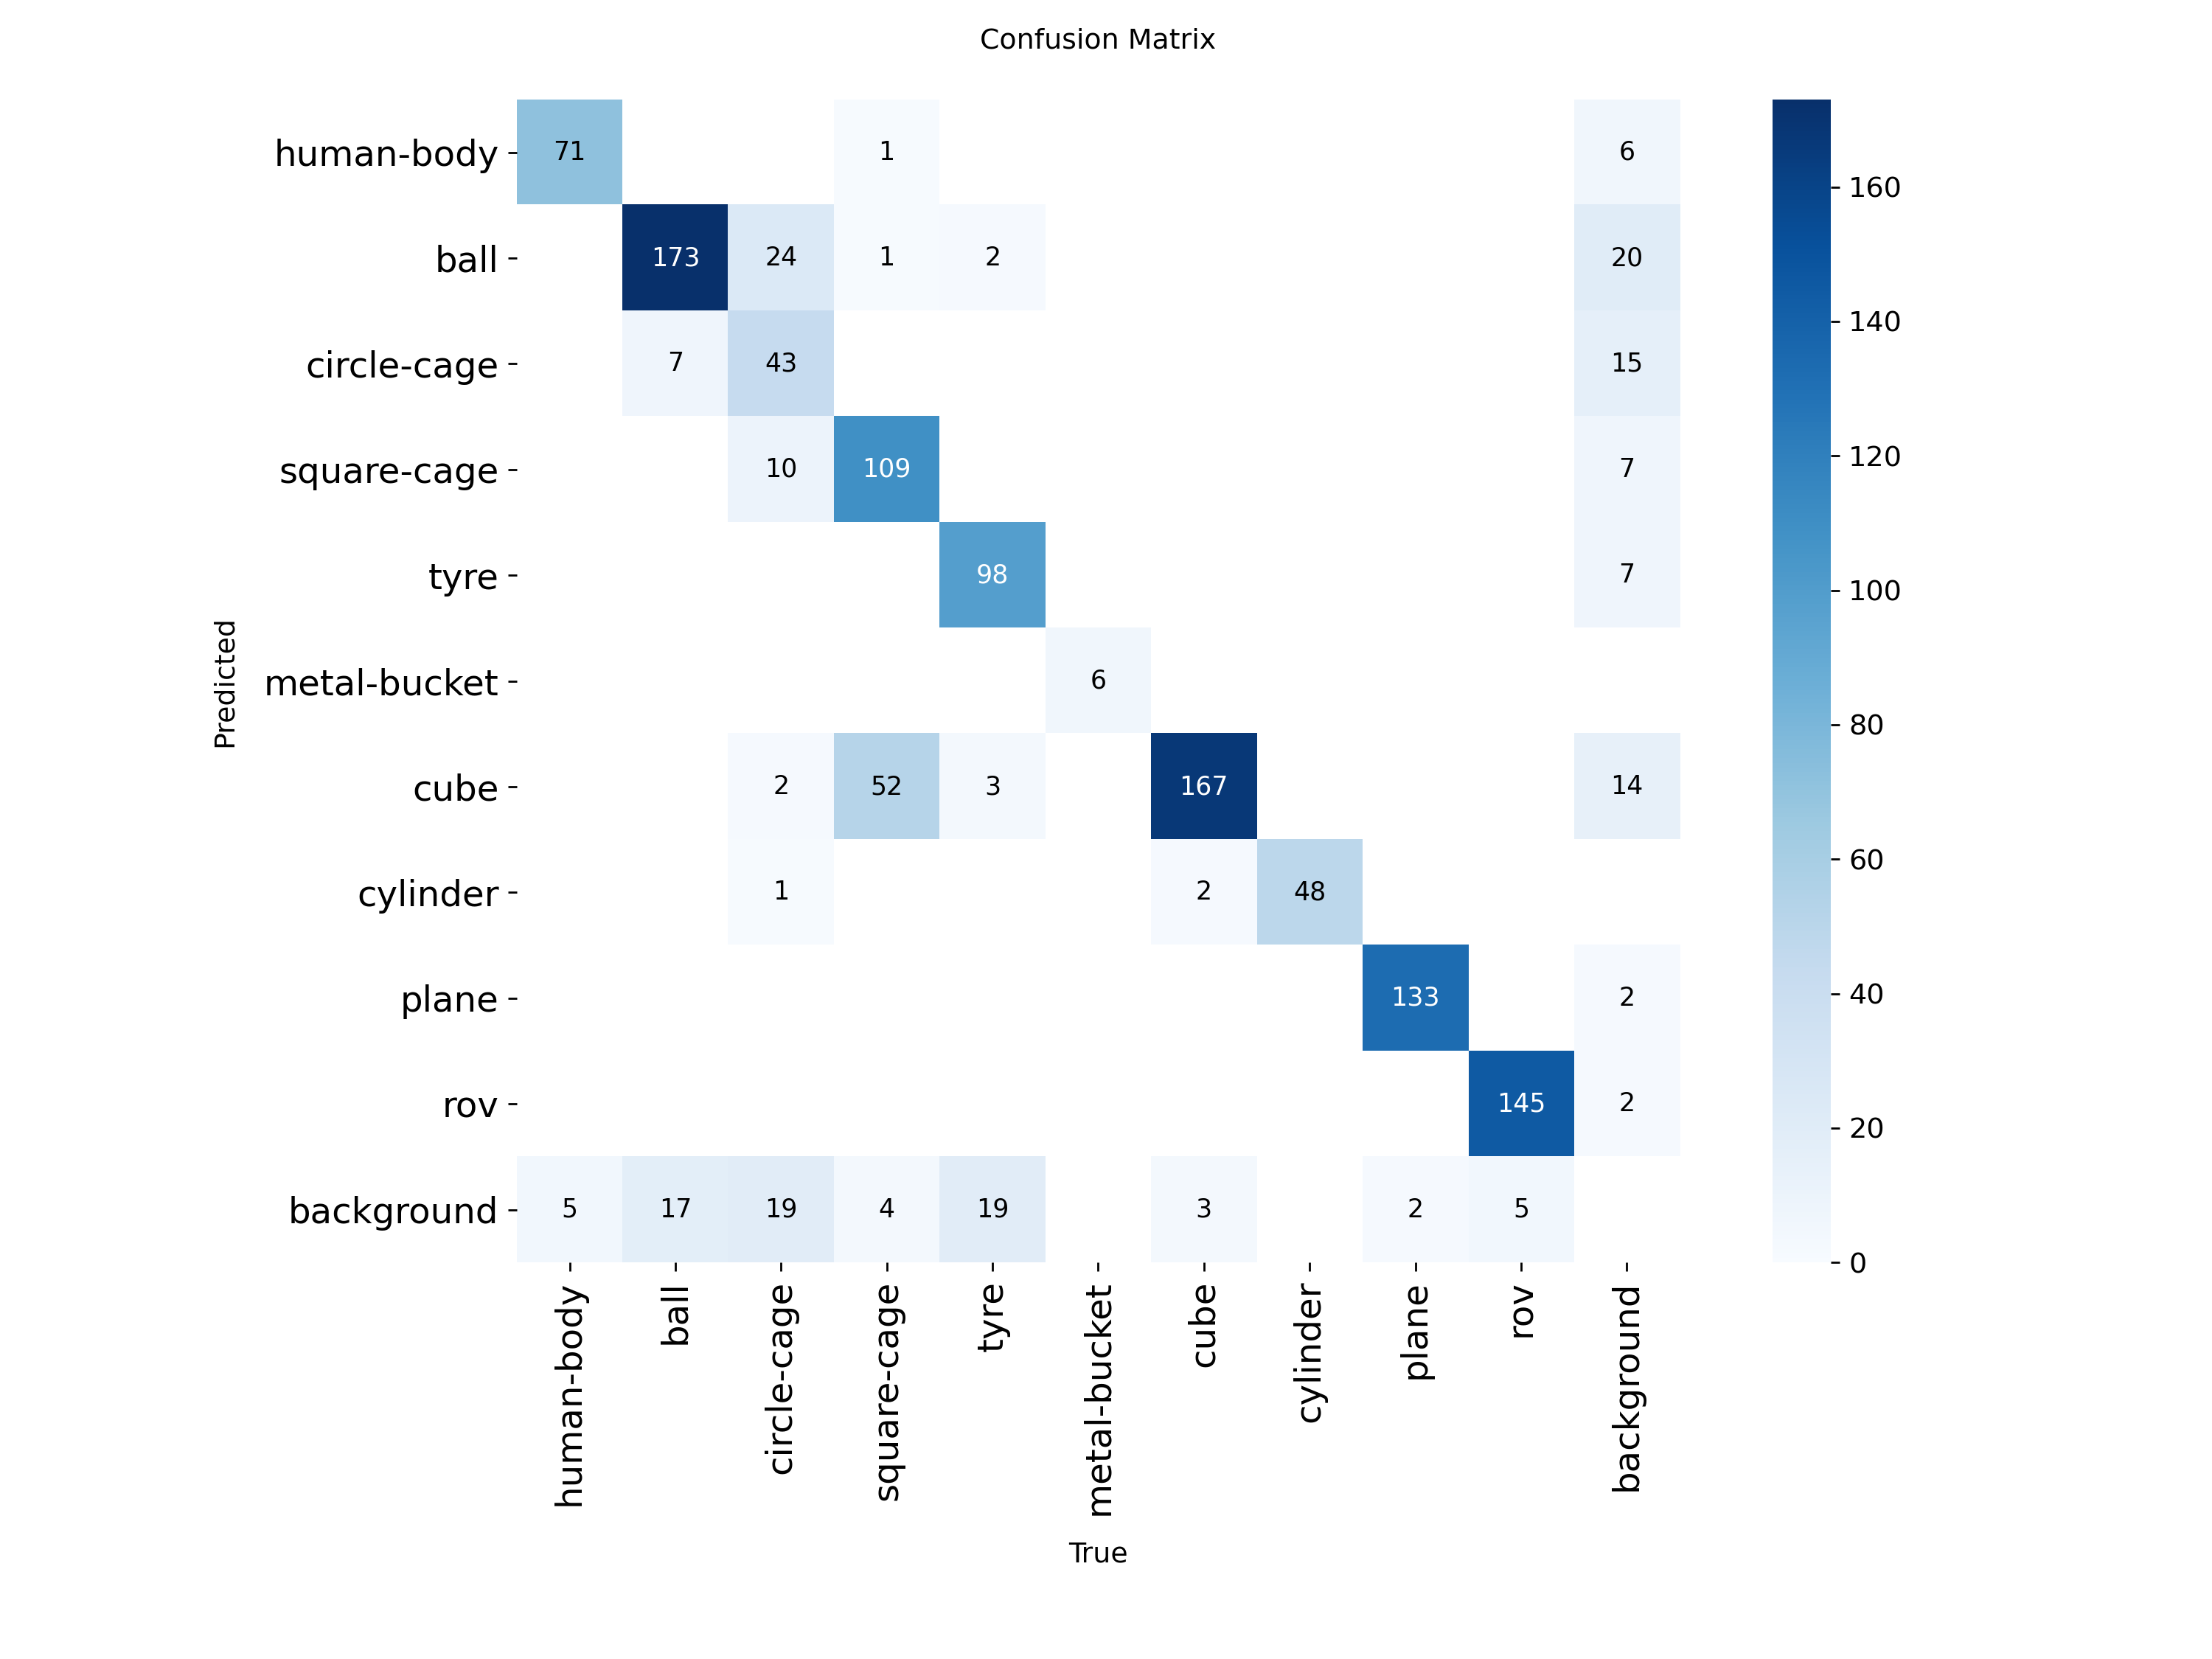

📈 confusion_matrix_normalized.png


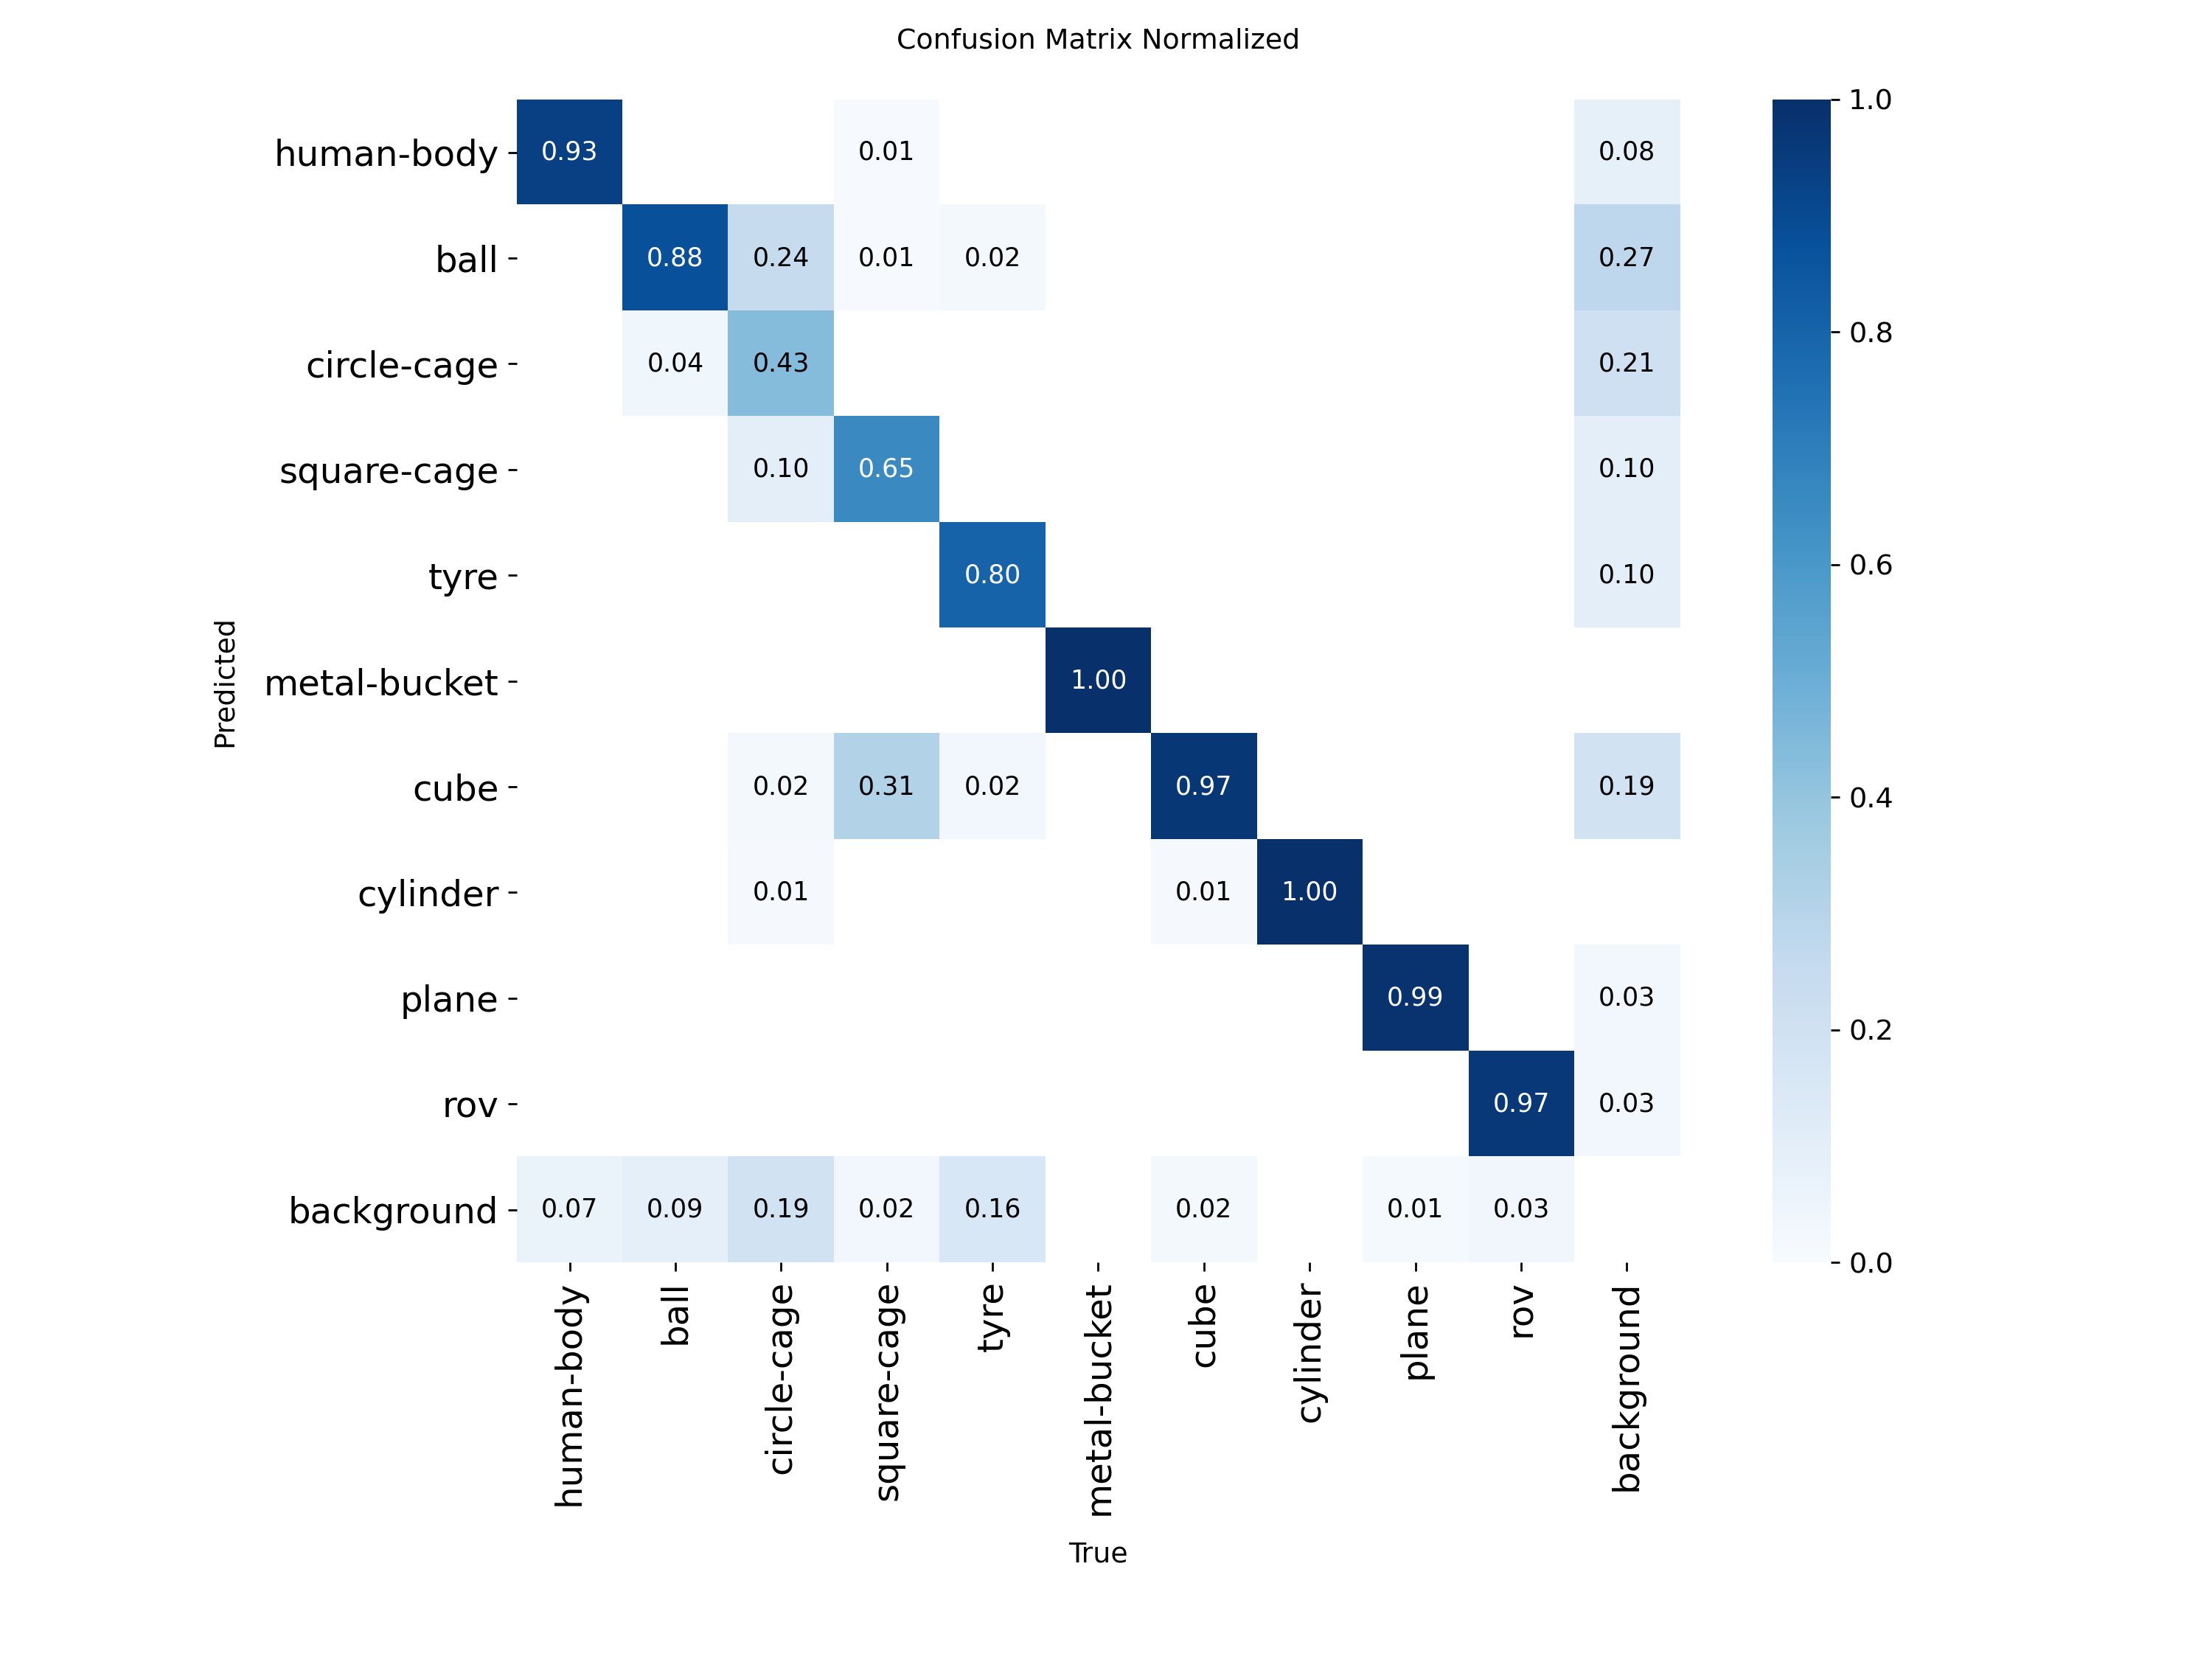

In [3]:
from IPython.display import display, Image, HTML
import os, glob

# 👉 change if you used a different name
run_dir = "runs_aquayolo/aquayolo_eval"

# 1) Curves + confusion matrices
to_show = [
    "BoxPR_curve.png",      # PR curve (per class)
    "BoxP_curve.png",       # Precision vs conf
    "BoxR_curve.png",       # Recall vs conf
    "BoxF1_curve.png",      # F1 vs conf
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
]
for f in to_show:
    p = os.path.join(run_dir, f)
    if os.path.exists(p):
        print("📈", f)
        display(Image(filename=p))
    else:
        print("⚠️ missing:", p)




## Show predictions


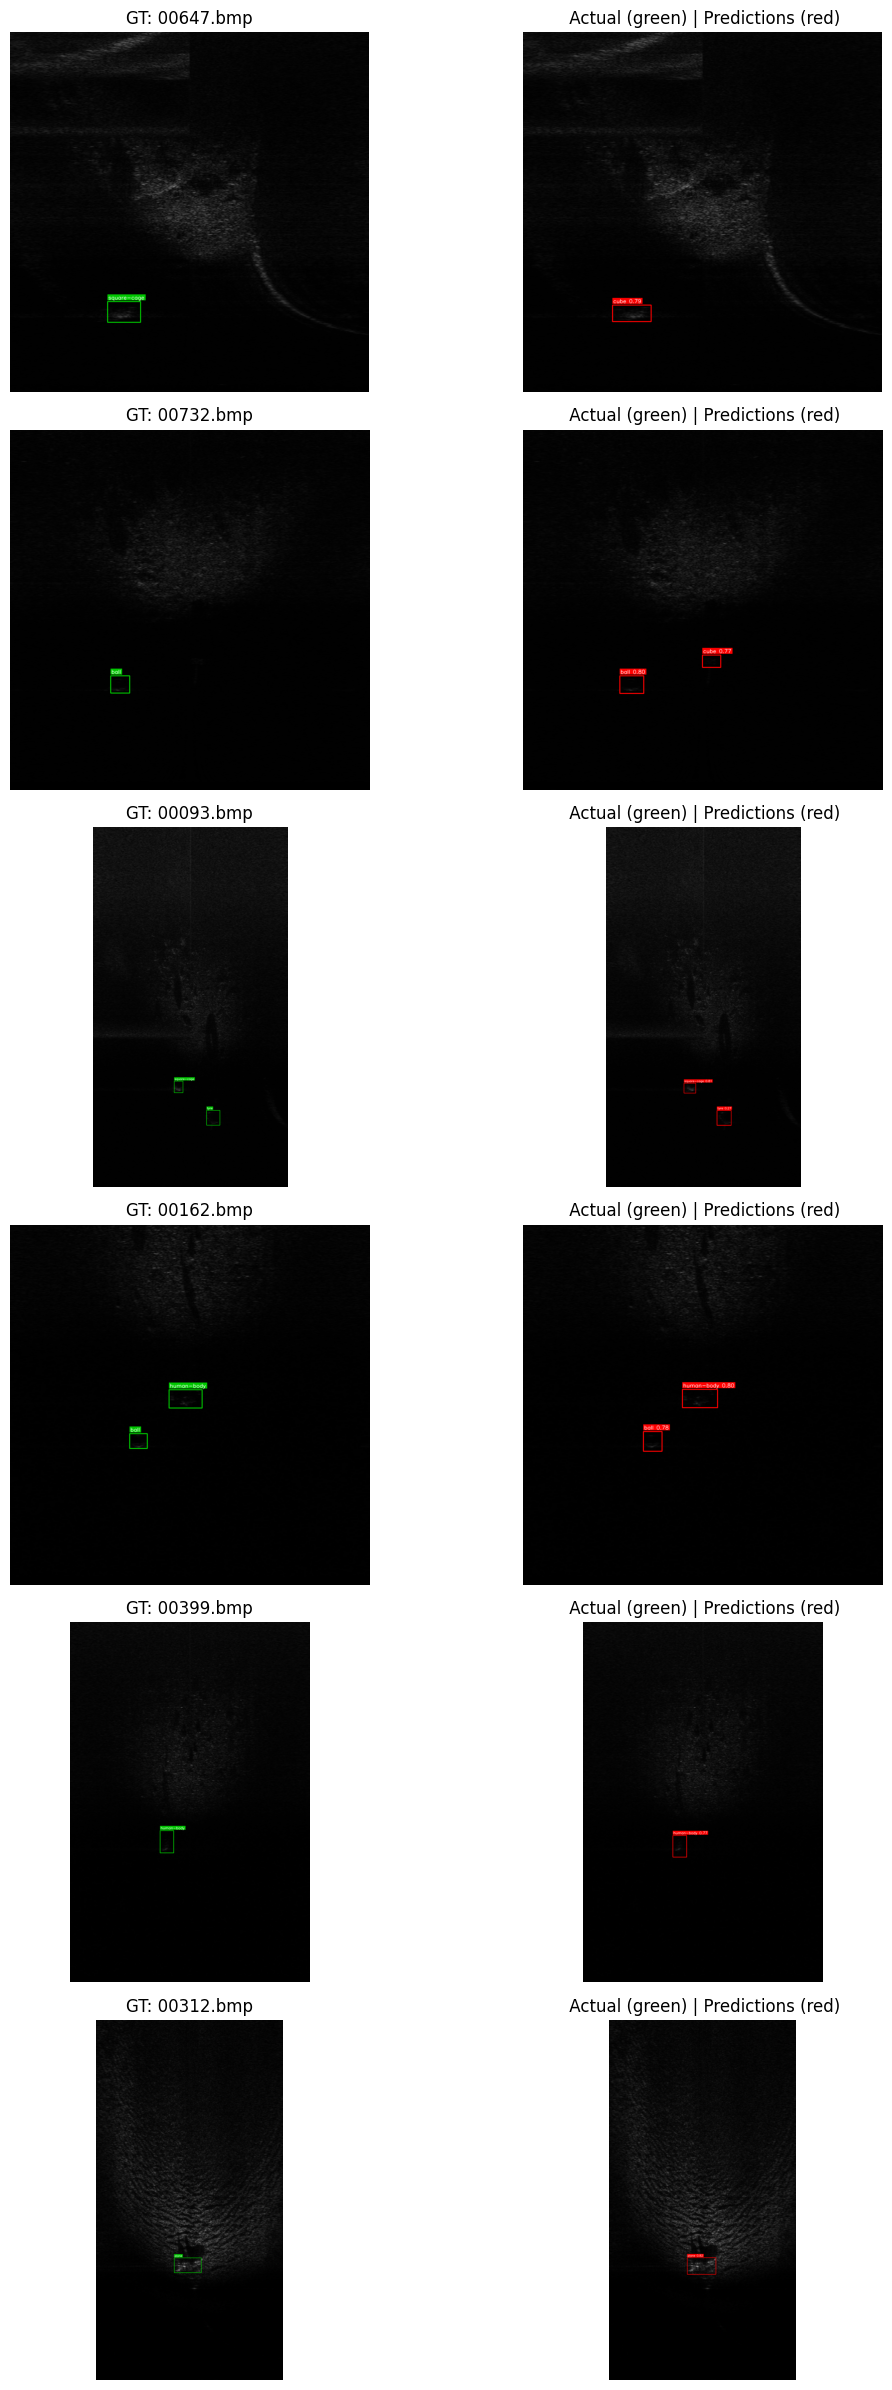

In [13]:



import cv2, random, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

%matplotlib inline


# ---- Config ----
data_root = Path("data/UATD")
images_dir = data_root / "images" / "test"   
labels_dir = data_root / "labels" / "test"
weights = "runs_aquayolo/aquayolo_m_SGD_640_4gpu_stable2/weights/best.pt"

num_samples = 6      # how many random examples to show
conf_thres = 0.25    # prediction confidence threshold
imgsz = 640          # inference size

# ---- Load model ----
model = YOLO(weights)
names = model.names

# ---- Helpers ----
def yolo_txt_to_xyxy(txt_line, img_w, img_h):
    """Convert 'cls cx cy w h' (normalized) to xyxy pixel coords."""
    c, cx, cy, w, h = txt_line.strip().split()
    c = int(float(c))
    cx, cy, w, h = map(float, (cx, cy, w, h))
    x1 = (cx - w/2) * img_w
    y1 = (cy - h/2) * img_h
    x2 = (cx + w/2) * img_w
    y2 = (cy + h/2) * img_h
    return c, int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))

def draw_boxes(img, boxes, labels=None, color=(255, 0, 0), thickness=2):
    """Draw boxes [(x1,y1,x2,y2), ...] with optional label strings."""
    for i, (x1, y1, x2, y2) in enumerate(boxes):
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        if labels is not None:
            txt = labels[i]
            (tw, th), bl = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            ytxt = max(0, y1 - 4)
            cv2.rectangle(img, (x1, ytxt - th - 4), (x1 + tw + 4, ytxt), color, -1)
            cv2.putText(img, txt, (x1 + 2, ytxt - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return img

# ---- Collect images ----
image_paths = sorted([p for p in images_dir.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}])
random.shuffle(image_paths)
image_paths = image_paths[:num_samples]

# ---- Inference + plot ----
cols = 2
rows = len(image_paths)
plt.figure(figsize=(12, 4 * rows))

for idx, img_path in enumerate(image_paths, 1):
    # Load image
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"⚠️ Could not read {img_path}")
        continue
    h, w = img_bgr.shape[:2]

    # --- Ground truth ---
    gt_boxes, gt_labels = [], []
    lbl_path = labels_dir / (img_path.stem + ".txt")
    if lbl_path.exists():
        with open(lbl_path, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                c, x1, y1, x2, y2 = yolo_txt_to_xyxy(line, w, h)
                gt_boxes.append((x1, y1, x2, y2))
                gt_labels.append(names.get(c, str(c)))
    gt_img = img_bgr.copy()
    gt_img = draw_boxes(gt_img, gt_boxes, gt_labels, color=(0, 200, 0), thickness=2)  # green for GT

    # --- Predictions ---
    # Run model; get per-image results
    res = model.predict(str(img_path), imgsz=imgsz, conf=conf_thres, verbose=False)[0]
    pred_boxes, pred_labels = [], []
    if res.boxes is not None and len(res.boxes) > 0:
        xyxy = res.boxes.xyxy.cpu().numpy().astype(int)
        cls  = res.boxes.cls.cpu().numpy().astype(int)
        conf = res.boxes.conf.cpu().numpy()
        for (x1, y1, x2, y2), c, p in zip(xyxy, cls, conf):
            pred_boxes.append((x1, y1, x2, y2))
            pred_labels.append(f"{names.get(c, str(c))} {p:.2f}")
    pred_img = img_bgr.copy()
    pred_img = draw_boxes(pred_img, pred_boxes, pred_labels, color=(0, 0, 255), thickness=2)  # red for Pred

    # --- Matplotlib show (convert BGR->RGB) ---
    gt_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    pr_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, 2*(idx-1)+1)
    plt.imshow(gt_rgb)
    plt.title(f"GT: {img_path.name}")
    plt.axis("off")

    plt.subplot(rows, cols, 2*(idx-1)+2)
    plt.imshow(pr_rgb)
    plt.title(" Actual (green) | Predictions (red)")
    plt.axis("off")

plt.tight_layout()
plt.show()
